## Imports and Setup

In [1]:
import os
import sys
sys.path.insert(0, "../utils/")
import geoutils
import cnn_utils
import config

import pandas as pd
import numpy as np
import geopandas as gpd

import torch
import torchsummary

pd.set_option('mode.chained_assignment', None)
%load_ext autoreload
%autoreload 2

## Load Dataset

INFO:root:{'INCOMPLETE': 0, 'BLUE_TARP': 1, 'HEALTHY_METAL': 2, 'IRREGULAR_METAL': 3, 'CONCRETE_CEMENT': 4}


Config: {'data': 'RGB_DOM', 'attribute': 'roof_material', 'batch_size': 32, 'n_workers': 4, 'n_epochs': 60, 'model': 'efficientnetb0', 'pretrained': True, 'resampler': 'RandomOverSampler', 'scheduler': 'ReduceLROnPlateau', 'optimizer': 'Adam', 'label_smoothing': 0.1, 'lr': 1e-05, 'img_size': 224, 'momentum': None, 'gamma': None, 'step_size': None, 'patience': 7, 'dropout': None, 'config_name': 'cnn-roof_material-efficientnetb0-RGB_DOM', 'rasters_dir': '../data/rasters/', 'vectors_dir': '../data/vectors/', 'tile_dir': '../data/tiles/', 'csv_dir': '../data/csv/', 'out_dir': '../outputs/', 'exp_dir': '../exp/', 'log_dir': '../logs/'}


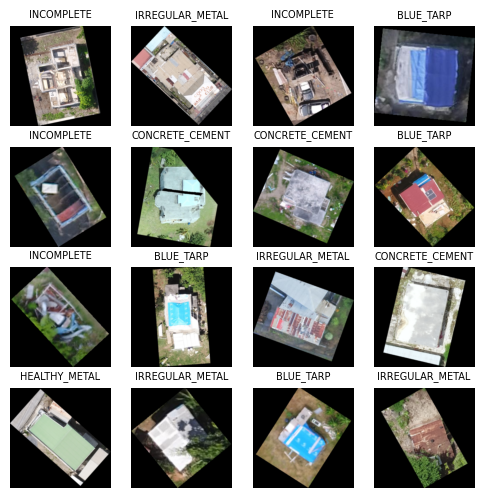

In [2]:
prefix = '.'
phases = ["TRAIN", "TEST"]
config_file = "../configs/cnn/cnn-roof_material-efficientnetb0-RGB_DOM.yaml"
c = config.load_config(config_file, prefix=prefix)
print(f"Config: {c}")
data, data_loader, classes = cnn_utils.load_dataset(c, phases, prefix)
cnn_utils.visualize_data(data, data_loader, phase='TEST', mode=c['data'].split('_')[0])

INFO:root:{'NO_ROOF': 0, 'GABLE': 1, 'HIP': 2, 'FLAT': 3}


Config: {'attribute': 'roof_type', 'data': 'RGB_DOM', 'batch_size': 32, 'n_workers': 4, 'n_epochs': 60, 'model': 'efficientnetb0', 'pretrained': True, 'resampler': 'RandomOverSampler', 'scheduler': 'ReduceLROnPlateau', 'optimizer': 'Adam', 'label_smoothing': 0.1, 'lr': 1e-05, 'img_size': 224, 'momentum': None, 'gamma': None, 'step_size': None, 'patience': 7, 'dropout': None, 'config_name': 'cnn-roof_type-efficientnetb0-RGB_DOM', 'rasters_dir': '../data/rasters/', 'vectors_dir': '../data/vectors/', 'tile_dir': '../data/tiles/', 'csv_dir': '../data/csv/', 'out_dir': '../outputs/', 'exp_dir': '../exp/', 'log_dir': '../logs/'}


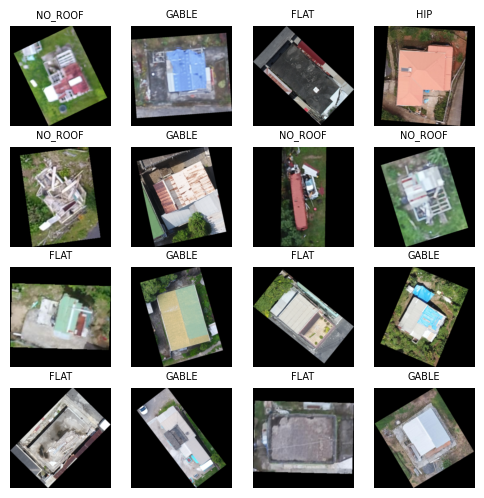

In [3]:
config_file = "../configs/cnn/cnn-roof_type-efficientnetb0-RGB_DOM.yaml"
c = config.load_config(config_file, prefix=prefix)
print(f"Config: {c}")
data, data_loader, classes = cnn_utils.load_dataset(c, phases, prefix)
cnn_utils.visualize_data(data, data_loader, phase='TEST', mode=c['data'].split('_')[0])

## Load Model

In [4]:
from torch_lr_finder import LRFinder
import torch.nn as nn
mode = c['data'].split("_")[0]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model, criterion, optimizer, scheduler = cnn_utils.load_model(
    n_classes=len(classes),
    model_type=c["model"],
    pretrained=c["pretrained"],
    scheduler_type=c["scheduler"],
    optimizer_type=c["optimizer"],
    lr=c["lr"],
    momentum=c["momentum"],
    gamma=c["gamma"],
    step_size=c["step_size"],
    patience=c["patience"],
    dropout=c["dropout"],
    device=device,
    mode=mode
)
#print(model)
torchsummary.summary(model, (3, c['img_size'], c['img_size']))

C:\Users\Issa\miniconda3\envs\GFDRR\lib\site-packages\torch_lr_finder\lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1